In [638]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [640]:
# load Rmat.csv
df = pd.read_csv('/Users/sebeyer/Desktop/MCS/Practical statistical learning/projects/project 4/Rmat.csv')

In [641]:
# load movie file
movies = pd.read_csv('/Users/sebeyer/Desktop/MCS/Practical statistical learning/projects/project 4/ml-1m/movies.dat', sep='::', engine='python', encoding='ISO-8859-1', names=['MovieID', 'Title', 'Genres'])

In [642]:
df.shape

(6040, 3706)

In [728]:
# save indices and columns while working in numpy

df_columns = df.columns.tolist()
df_indices = df.index.tolist()

In [714]:
df.head()

,m1,m10,m100,m1000,m1002,m1003,m1004,m1005,m1006,m1007,...,m99,m990,m991,m992,m993,m994,m996,m997,m998,m999
u1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u10,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1000,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1001,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [658]:
movies.shape

(3883, 3)

In [660]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


System I: Recommendation Based on Popularity
-> Recommend top ten most popular movies

Definition of 'most popular': highest average rating, but exclude movies with <10 reviews

In [684]:
# identify movies with at least 10 non-NA reviews
valid_movies = df.columns[df.notna().sum() >= 10]

# calculate the average score for those movies
av_ratings = df[valid_movies].mean()

# identify the top 10 most popular movies based on the highest average score
top_ten_movies_indices = av_ratings.nlargest(10).index.map(lambda x: x[1:]).map(int).tolist()
# top_ten_movies_indeces = list(map(int, top_ten_movies.index))

# map movie IDs to movie titles
top_ten_movie_names = movies.set_index('MovieID').loc[top_ten_movies_indeces].iloc[:,0:2].reset_index()

In [690]:
av_ratings

m1       4.146846
m10      3.540541
m100     3.062500
m1000    3.050000
m1003    2.942149
           ...   
m994     4.095556
m996     2.906250
m997     3.357143
m998     3.010753
m999     3.283217
Length: 3260, dtype: float64

In [696]:
# also create list of the entire overall movie ranking as preparation for Section 2
av_ratings_ranked = av_ratings.sort_values(ascending=False)
av_ratings_ranked_indices = np.asarray(av_ratings_ranked.index.map(lambda x: x[1:]).map(int).tolist())
np.save('top_movies.npy', av_ratings_ranked_indeces)

In [702]:
# fct to show Movie ID together with title and poster 
def show_poster(df, index):
    # Get the row
    row = df.iloc[index]
    
    # Load the image
    image_path = '/Users/sebeyer/Desktop/MCS/Practical statistical learning/projects/project 4/MovieImages/' + str(row['MovieID']) + '.jpg'
    image = Image.open(image_path)
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Movie ID: {row['MovieID']} - Title: {row['Title']}", fontsize=14, color="black")
    plt.show()


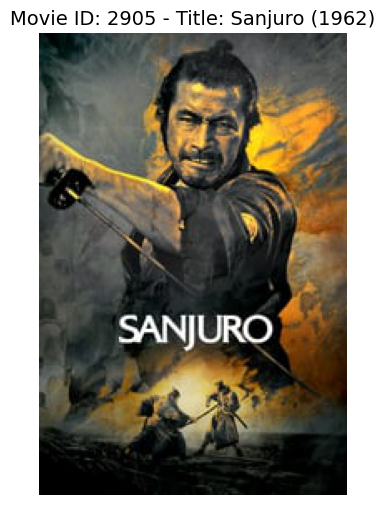

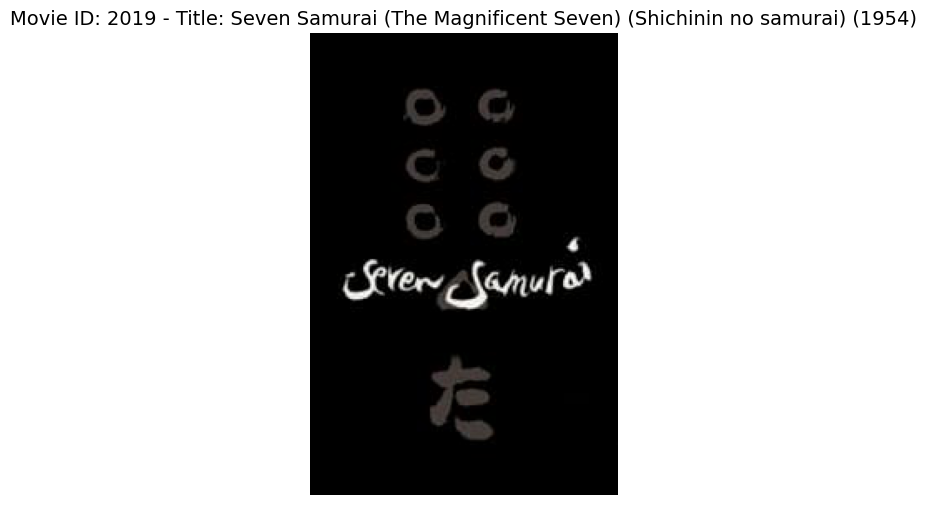

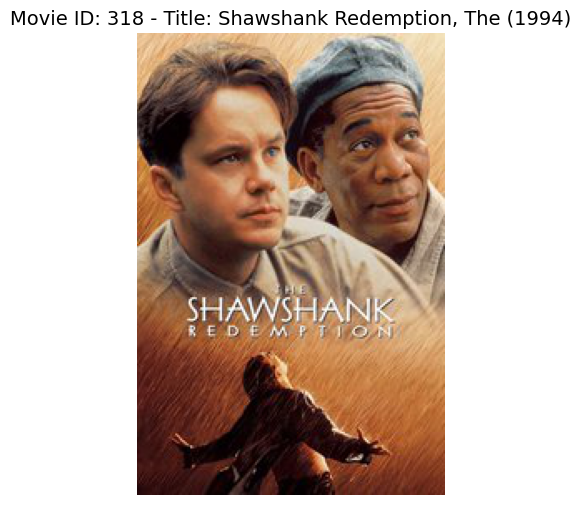

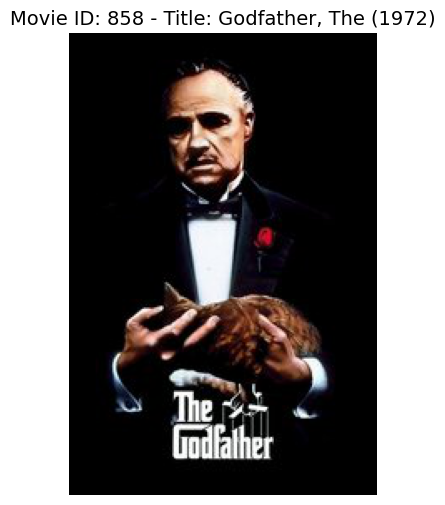

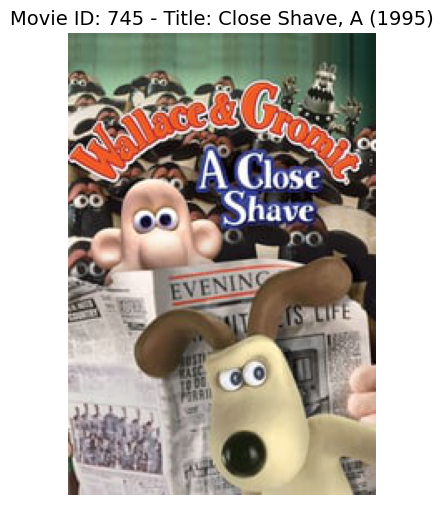

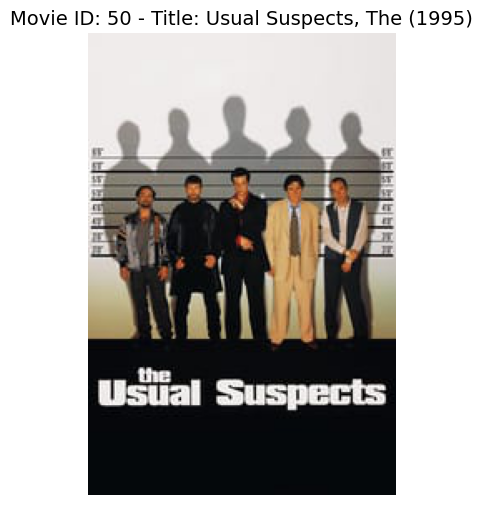

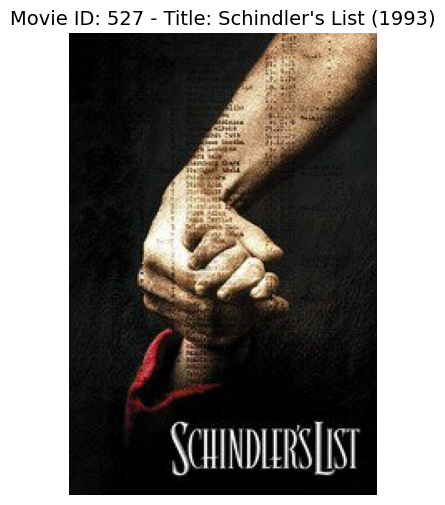

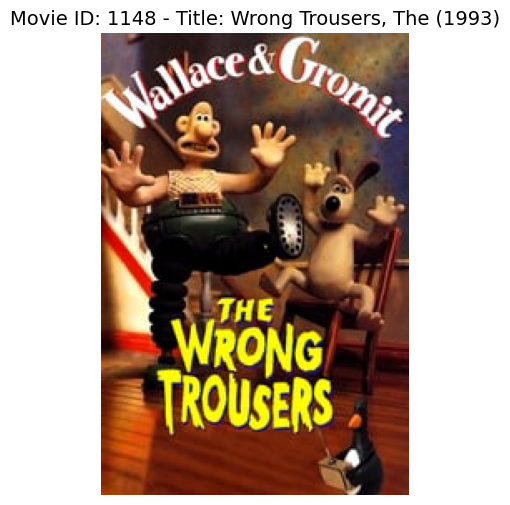

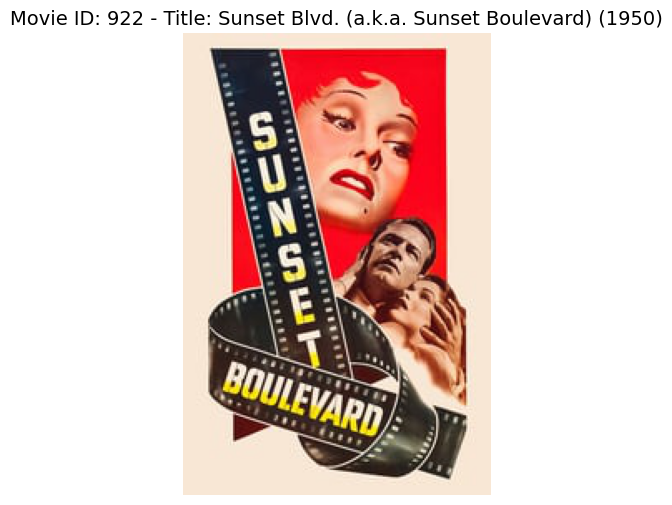

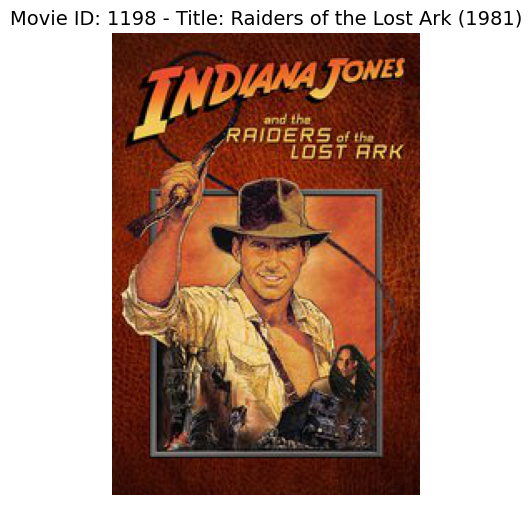

In [704]:
for i in range(len(top_ten_movie_names)):
    show_poster(top_ten_movie_names, i)

System II: Recommendation Based on IBCF

In [706]:
# Let R denote the 6040-by-3706 rating matrix
R = df.to_numpy()
R.shape

(6040, 3706)

In [748]:
R

array([[ 5., nan, nan, ..., nan, nan, nan],
       [ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [750]:
# 1. Normalize the rating matrix by centering each row. This means subtracting row means from each row
# of the rating matrix R. Row means should be computed based on non-NA entries. For instance, the
# mean of a vector like (2, 4, NA, NA) should be 3.
R_centered = R - np.nanmean(R, axis=1, keepdims=True)
R_centered.shape

(6040, 3706)

In [786]:
# 2. Compute the (transformed) Cosine similarity among the 3,706 movies. For movies i and j, let Iij
# denote the set of users who rated both movies i and j. We decide to ignore similarities computed based
# on less than three user ratings. 

# non-NaN values
mask = (~np.isnan(R_centered)).astype(int)

# replace NaNs with 0 for dot product computations
R_filled = np.nan_to_num(R_centered, nan=0.0)

# numerator
numerator = np.dot(R_filled.T, R_filled)

# denominator
squared_R = R_filled**2
a = np.dot(mask.T, squared_R)  # valid squared sums for each pair
denominator = np.sqrt(a.T * a)

# number of shared observations for each movie pair
shared_counts = np.dot(mask.T, mask)

# exclude pairs with fewer than 3 shared observations
valid_pairs = shared_counts > 2

# compute cosine similarity with valid pairs
cos_similarity = np.where(
    valid_pairs,
    numerator / denominator,  # accept NaNs, no small value added
    np.nan
    )

# scaling 
S = 0.5 + 0.5 * cos_similarity

/var/folders/5_/rz7x24m52rs650hvdb44zwhc0000gn/T/ipykernel_1417/2768679219.py:28: RuntimeWarning: invalid value encountered in divide
  numerator / denominator,  # accept NaNs, no small value added


In [788]:
S

array([[1.        , 0.51210553, 0.39199995, ..., 0.5140432 , 0.38377183,
        0.41450545],
       [0.51210553, 1.        , 0.54745829, ..., 0.66873273, 0.44828951,
        0.60081163],
       [0.39199995, 0.54745829, 1.        , ..., 0.26957569, 0.47892265,
        0.6128149 ],
       ...,
       [0.5140432 , 0.66873273, 0.26957569, ..., 1.        , 0.64263547,
        0.4606457 ],
       [0.38377183, 0.44828951, 0.47892265, ..., 0.64263547, 1.        ,
        0.64272702],
       [0.41450545, 0.60081163, 0.6128149 , ..., 0.4606457 , 0.64272702,
        1.        ]])

In [790]:
# Display the pairwise similarity values from the S matrix (you obtained at Step 2) for the following
# specified movies: “m1”, “m10”, “m100”, “m1510”, “m260”, “m3212”. Please round the results to
# 7 decimal places.

print(f'Similarity m1, m10: {np.round(S[df_columns.index('m1'),df_columns.index('m10')], decimals=7)}')
print(f'Similarity m1, m100: {np.round(S[df_columns.index('m1'),df_columns.index('m100')], decimals=7)}')
print(f'Similarity m1, m1510: {np.round(S[df_columns.index('m1'),df_columns.index('m1510')], decimals=7)}')
print(f'Similarity m1, m260: {np.round(S[df_columns.index('m1'),df_columns.index('m260')], decimals=7)}')
print(f'Similarity m1, m3212: {np.round(S[df_columns.index('m1'),df_columns.index('m3212')], decimals=7)}')

print(f'Similarity m10, m100: {np.round(S[df_columns.index('m10'),df_columns.index('m100')], decimals=7)}')
print(f'Similarity m10, m1510: {np.round(S[df_columns.index('m10'),df_columns.index('m1510')], decimals=7)}')
print(f'Similarity m10, m260: {np.round(S[df_columns.index('m10'),df_columns.index('m260')], decimals=7)}')
print(f'Similarity m10, m3212: {np.round(S[df_columns.index('m10'),df_columns.index('m3212')], decimals=7)}')

print(f'Similarity m100, m1510: {np.round(S[df_columns.index('m100'),df_columns.index('m1510')], decimals=7)}')
print(f'Similarity m100, m260: {np.round(S[df_columns.index('m100'),df_columns.index('m260')], decimals=7)}')
print(f'Similarity m100, m3212: {np.round(S[df_columns.index('m100'),df_columns.index('m3212')], decimals=7)}')

print(f'Similarity m1510, m260: {np.round(S[df_columns.index('m1510'),df_columns.index('m260')], decimals=7)}')
print(f'Similarity m1510, m3212: {np.round(S[df_columns.index('m1510'),df_columns.index('m3212')], decimals=7)}')

print(f'Similarity m260, m3212: {np.round(S[df_columns.index('m260'),df_columns.index('m3212')], decimals=7)}')

Similarity m1, m10: 0.5121055
Similarity m1, m100: 0.3919999
Similarity m1, m1510: nan
Similarity m1, m260: 0.7411482
Similarity m1, m3212: nan
Similarity m10, m100: 0.5474583
Similarity m10, m1510: nan
Similarity m10, m260: 0.5343338
Similarity m10, m3212: nan
Similarity m100, m1510: nan
Similarity m100, m260: 0.3296943
Similarity m100, m3212: nan
Similarity m1510, m260: nan
Similarity m1510, m3212: nan
Similarity m260, m3212: nan


In [826]:
# 3. Let S denote the 3706-by-3706 similarity matrix computed in previous step. For each row, sort the
# non-NA similarity measures and keep the top 30, setting the rest to NA. This new similarity matrix,
# still denoted as S, is no longer symmetric. Save this matrix. Note that some rows of the S matrix may
# contain fewer than 30 non-NA values.

# confusing... interpretation: only retain top 30 non-NA values but retain initial order as otherwise the matrix would loose all meaning...

# ensure that nan values are listed last when sorting rows in descending order
nan_replaced = np.where(np.isnan(S), -np.inf, S)
    
# indices of the top 30 values along each row
top_30_indices = np.argsort(nan_replaced, axis=1)[:, -30:]
    
# mask of the same shape as the input array
mask = np.zeros_like(S, dtype=bool)
row_indices = np.arange(S.shape[0])[:, None]
mask[row_indices, top_30_indices] = True
    
# retain only the top 30 values; set the rest to np.nan
S = np.where(mask, S, np.nan)

In [836]:
# 4. Create a function named myIBCF:
def myIBCF(newuser, S=S, overall_movie_ranking=av_ratings_ranked_indeces):
    """
    input: newuser, a 3706-by-1 vector (denoted as w) containing ratings for the 3,706 movies from a new user
    S: similarity matrix
    overall_movie_ranking: np array of movie indeces ranked by popularity
    
    output: recommend the top ten movies to this new user, using the column names of the rating matrix R (i.e., “m” +MovieID).
    If fewer than 10 predictions are non-NA, select the remaining movies based on the popularity defined in
    System 1, prioritizing the most popular ones and excluding those already rated by the user.

    While this is not defined in the instructions, the recommendations will exclude the movies the use has already rated
    Ties are handled by default behavior
    """
    # initialize vectors
    w = newuser
    w_predictions = np.zeros((w.shape))
    w_predictions[:] = np.nan
    
    # identify movies not yet rated by user
    user_ratings = ~np.isnan(w) 
    no_ratings = np.isnan(w)  

    # iterate over all movies not yet rated by user
    for i in np.where(no_ratings)[0]:
        
        # identify valid similarity scores for movie i
        valid_similarities_mask = ~np.isnan(S[i]) & user_ratings
    
        # Compute numerator and denominator
        numerator = np.sum(S[i, valid_similarities_mask] * w[valid_similarities_mask])
        denominator = np.sum(S[i, valid_similarities_mask])
    
        # Calculate predicted rating for movie i
        if denominator > 0:
            w_predictions[i] = numerator / denominator
        else:
            w_predictions[i] = np.nan

    # obtain the indices that would sort the prediction array in descending order, ensuring that NANs are considered lowest
    nan_mask = np.isnan(w_predictions)
    nan_as_lowest = np.where(nan_mask, -np.inf, w_predictions)
    w_pred_sorted_indices = np.argsort(nan_as_lowest)[::-1]
    
    # If fewer than 10 predictions are non-NA, select the remaining movies based on the popularity defined in
    # System 1, prioritizing the most popular ones and excluding those already rated by the user.
    if np.count_nonzero(~np.isnan(w_predictions)) <10:
        i = np.count_nonzero(~np.isnan(w_predictions))
        while i < 10:
            j=0
            while True:
                if overall_movie_ranking[j] in w_pred_sorted_indices[:i]: # check if overall popular movies are already listed in the predictions for this user
                    j += 1
                else:
                    w_pred_sorted_indices[i] = overall_movie_ranking[j]
                    break
            i+=1 
            
    recommendations = [df_columns[w_pred_sorted_indices[i]] for i in range(10)]

    return recommendations

In [838]:
# test myIBCF function
av_ratings_ranked_indeces = np.load('top_movies.npy')

#u1181
w = R[df_indices.index('u1181'),:]
predictions = myIBCF(w, S=S, overall_movie_ranking=av_ratings_ranked_indeces)
print(predictions)

#A hypothetical user who rates movie “m1613” with 5 and movie “m1755” with 4.
w = np.empty((3706,))
w[:] = np.nan
w[df_columns.index('m1613')] = 5
w[df_columns.index('m1755')] = 4
predictions = myIBCF(w, S=S, overall_movie_ranking=av_ratings_ranked_indeces)
print(predictions)

['m3732', 'm749', 'm3899', 'm1734', 'm1039', 'm2082', 'm427', 'm337', 'm3789', 'm249']
['m765', 'm3269', 'm1017', 'm1688', 'm340', 'm2808', 'm2846', 'm2945', 'm691', 'm2688']
